<a href="https://colab.research.google.com/github/vivekwisdom/NLP/blob/develop/NER/Named_Entity_Recognition_ELMo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Source]('https://github.com/nxs5899/Named-Entity-Recognition_DeepLearning-keras')

In [6]:
!pip install seqeval version_information

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=a4b5c24cd8895bbcfc54dce2ae40bb61ec203e0098087a9e7254b4f74886fa9b
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for version-information: filename=version_information-1.0.3-cp36-none-any.whl size=3880 sha256=228a2e6283446f10c08c64bc8bf7bc814c342c6cfb1195a9a3b0aa27f1c4ff86
  Stored in directory: /root/.cache/pip/wheels/1f/4c/b3/1976ac11dbd802723b564de1acaa453a72c36c95827e576321
Successfully built seqeval version-information


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

%load_ext version_information
%version_information pandas, numpy, keras, tensorflow, sklearn

print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Software versions
Python 3.6.8 64bit [GCC 8.0.1 20180414 (experimental) [trunk revision 259383]
IPython 5.5.0
OS Linux 4.14.137+ x86_64 with Ubuntu 18.04 bionic
pandas 0.24.2
numpy 1.16.5
keras 2.2.5
tensorflow 1.14.0
sklearn 0.21.3
Thu Sep 19 11:27:09 2019 UTC

In [0]:
plt.style.use("ggplot")

In [10]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis=1)
data = data.fillna(method="ffill")
data.tail(12)

,Sentence #,Word,Tag
1048563,Sentence: 47958,exploded,O
1048564,Sentence: 47958,upon,O
1048565,Sentence: 47958,impact,O
1048566,Sentence: 47958,.,O
1048567,Sentence: 47959,Indian,B-gpe
1048568,Sentence: 47959,forces,O
1048569,Sentence: 47959,said,O
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O


In [11]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

35179

In [12]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

17

In [0]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [14]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [15]:
sentences = getter.sentences
print(len(sentences))


47959


In [16]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


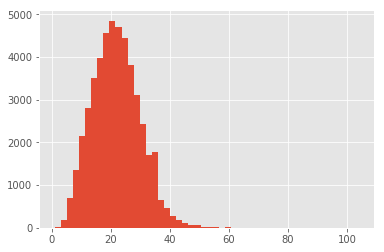

In [17]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [18]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}
print(words2index['London'])
print(tags2index['B-geo'])

14003
14


In [19]:
max_len = 50
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

['Israeli',
 'officials',
 'say',
 'Prime',
 'Minister',
 'Ariel',
 'Sharon',
 'will',
 'undergo',
 'a',
 'medical',
 'procedure',
 'Thursday',
 'to',
 'close',
 'a',
 'tiny',
 'hole',
 'in',
 'his',
 'heart',
 'discovered',
 'during',
 'treatment',
 'for',
 'a',
 'minor',
 'stroke',
 'suffered',
 'last',
 'month',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [20]:
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([13,  3,  3,  4,  6,  6,  6,  3,  3,  3,  3,  3, 16,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
      dtype=int32)

In [21]:
y[0], new_X[0]

(array([ 3,  3,  3,  3,  3,  3, 14,  3,  3,  3,  3,  3, 14,  3,  3,  3,  3,
         3, 13,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       dtype=int32),
 ['Thousands',
  'of',
  'demonstrators',
  'have',
  'marched',
  'through',
  'London',
  'to',
  'protest',
  'the',
  'war',
  'in',
  'Iraq',
  'and',
  'demand',
  'the',
  'withdrawal',
  'of',
  'British',
  'troops',
  'from',
  'that',
  'country',
  '.',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword'])

In [22]:
np.array(new_X).shape, y.shape

((47959, 50), (47959, 50))

In [0]:
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2018)

In [24]:
X_tr[0], X_te[0], y_tr[0], y_te[0]

(['At',
  'least',
  'five',
  'policemen',
  'have',
  'been',
  'killed',
  'in',
  'a',
  'militant',
  'attack',
  'on',
  'a',
  'security',
  'camp',
  'in',
  'Indian-controlled',
  'Kashmir',
  '.',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword'],
 ['They',
  'say',
  'the',
  'documents',
  'were',
  'found',
  'in',
  'the',
  'computer',
  'of',
  'FARC',
  'leader',
  'Raul',
  'Reyes',
  'during',
  'a',
  'cross-border',
  'raid',
  'in',
  'Ecuador',
  'last',
  'month',
  '.',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'P

In [0]:
batch_size = 32
sess = tf.Session()
K.set_session(sess)

In [0]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [0]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [28]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [40]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50, 1024)     0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 1024)     6295552     lambda_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 50, 1024)     6295552     bidirectional_1[0][0]            
____________________________________________________________________________________________

In [0]:
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [36]:
np.array(X_tr).shape, y_tr.shape, np.array(X_te).shape, y_te.shape

((38816, 50), (38816, 50, 1), (4796, 50), (4796, 50))

In [0]:
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [38]:
np.array(X_tr).shape, y_tr.shape, np.array(X_val).shape, y_val.shape

((38816, 50), (38816, 50, 1), (4320, 50), (4320, 50, 1))

In [39]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val), batch_size=batch_size, epochs=3, verbose=1)

Train on 38816 samples, validate on 4320 samples
Epoch 1/3
38816/38816 [==============================] - 1384s 36ms/step - loss: 0.0631 - acc: 0.9817 - val_loss: 0.0426 - val_acc: 0.9862
Epoch 2/3
38816/38816 [==============================] - 1376s 35ms/step - loss: 0.0405 - acc: 0.9870 - val_loss: 0.0342 - val_acc: 0.9885
Epoch 3/3
38816/38816 [==============================] - 1374s 35ms/step - loss: 0.0339 - acc: 0.9885 - val_loss: 0.0254 - val_acc: 0.9912


# Fix abbove cell

In [41]:
X_te = X_te[:149*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)

4768/4768 [==============================] - 113s 24ms/step


In [0]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])


In [43]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 82.4%


In [44]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      org       0.71      0.65      0.68      2061
      per       0.73      0.80      0.77      1677
      tim       0.86      0.85      0.86      2148
      gpe       0.95      0.94      0.94      1591
      geo       0.83      0.91      0.87      3720
      eve       0.46      0.36      0.41        33
      art       0.25      0.20      0.22        49
      nat       0.50      0.23      0.31        22

micro avg       0.82      0.83      0.82     11301
macro avg       0.81      0.83      0.82     11301



In [45]:
i = 390
p = model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "PADword":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

Word            Pred : (True)
Citing         :O     (O)
a              :O     (O)
draft          :O     (O)
report         :O     (O)
from           :O     (O)
the            :O     (O)
U.S.           :B-org (B-org)
Government     :I-org (I-org)
Accountability :I-org (O)
office         :O     (O)
,              :O     (O)
The            :B-org (B-org)
New            :I-org (I-org)
York           :I-org (I-org)
Times          :I-org (I-org)
said           :O     (O)
Saturday       :B-tim (B-tim)
the            :O     (O)
losses         :O     (O)
amount         :O     (O)
to             :O     (O)
between        :O     (O)
1,00,000       :O     (O)
and            :O     (O)
3,00,000       :O     (O)
barrels        :O     (O)
a              :O     (O)
day            :O     (O)
of             :O     (O)
Iraq           :B-geo (B-geo)
's             :O     (O)
declared       :O     (O)
oil            :O     (O)
production     :O     (O)
over           :O     (O)
the            :O     (O)
pa